In [1]:
import functions_idealized
import functions_grid
import functions_realistic
import scipy as sc, scipy.io
import numpy as np
import matplotlib.cm as cm
import colormap_ibcao
import cmocean as cmo
import colormap_ibcao
cmap, norm = colormap_ibcao.Colormap()

import matplotlib.pyplot as plt
%matplotlib inline

# Variables

In [2]:
x_final = 120
y_final = int(0.75 * x_final)

extension_m = 108061

smooth_factor = 0.2
max_norm_depth_diff = 0.70834736504

search_x = [-1000000, -1450000, -1750000, -1400000]

# Set up

In [3]:
ibcao_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/IBCAO_V3_500m_RR.grd')
x_ibcao = ibcao_file.variables['x'][:]
y_ibcao = ibcao_file.variables['y'][:]
z_ibcao = ibcao_file.variables['z'][:]
xl=-1750e3; xr=-1000e3; yb=1300e3; yt=2050e3
xmin = np.where(x_ibcao==xl)[0][0]
xmax = np.where(x_ibcao==xr)[0][0]
ymin = np.where(y_ibcao==yb)[0][0]
ymax = np.where(y_ibcao==yt)[0][0]
x_region = x_ibcao[xmin:xmax]
y_region = y_ibcao[ymin:ymax]
z_region = z_ibcao[ymin:ymax, xmin:xmax]

# 1. Mackenzie Canyon Dimensions

In [35]:
w_break, w_mid, w_head, width_f, x_wall, mouth, length, y_wall_1300, y_wall, adjust, cR, L, y_base, y_break,\
y_coast, y_head, fluid_depth, z_bottom, z_break, z_wall, p = functions_idealized.define_Mackenzie_measurements()

# 2. Base Region

In [5]:
lon_s_corners_can, lat_s_corners_can = functions_grid.match_domain(x_wall, y_wall, search_x)

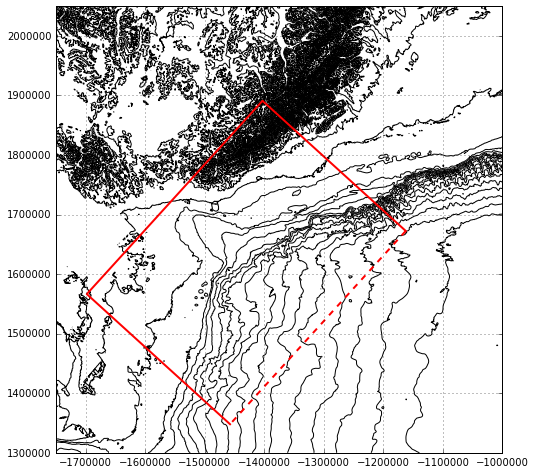

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')
ax.plot(lon_s_corners_can, lat_s_corners_can, 'r', linewidth=2)
ax.plot(lon_s_corners_can[::3], lat_s_corners_can[::3], 'r', linewidth=2, linestyle='--')

# 3. Extended Region

In [7]:
x_wall_ext = x_wall + extension_m

In [8]:
lon_s_corners, lat_s_corners = functions_grid.match_domain(x_wall_ext, y_wall, search_x)

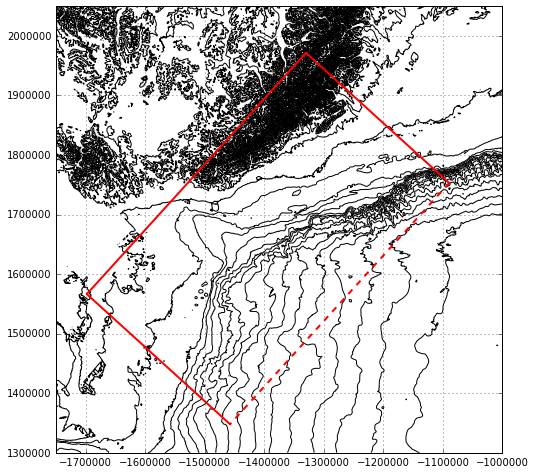

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')
ax.plot(lon_s_corners, lat_s_corners, 'r', linewidth=2)
ax.plot(lon_s_corners[::3], lat_s_corners[::3], 'r', linewidth=2, linestyle='--')

# 4. Extended Coordinates

In [10]:
nx, ny = x_final, y_final

In [11]:
lon_g_corners, lat_g_corners = functions_grid.transform_coords(lon_s_corners, lat_s_corners, 'SG')

lonW, latW, lonE, latE = functions_grid.get_southern_points(lon_g_corners, lat_g_corners)

lon_g_grid, lat_g_grid = functions_grid.create_grid(nx, ny, lonW, latW, lonE, latE)

lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')

4.50141506581
4.50141337134


(120, 90)

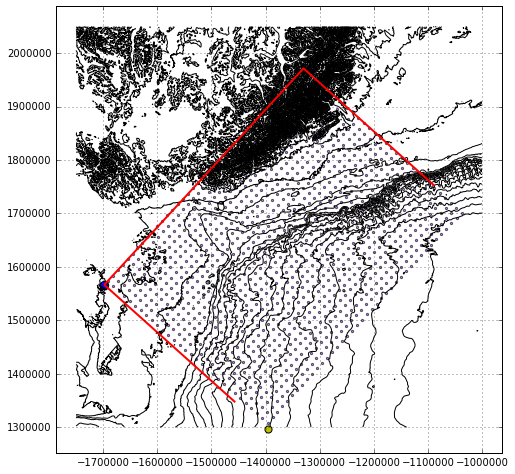

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='solid')
ax.scatter(lon_s_grid[::3,::3], lat_s_grid[::3,::3], c='BlueViolet', s=5, alpha=0.6)
ax.plot(lon_s_corners, lat_s_corners, 'r', linewidth=2)
lon_s_grid.shape

# 5. Extended Bathymetry

In [13]:
z_canyon = functions_realistic.extract_canyon(lon_s_grid, lat_s_grid, x_region, y_region, z_region)

(90, 120)

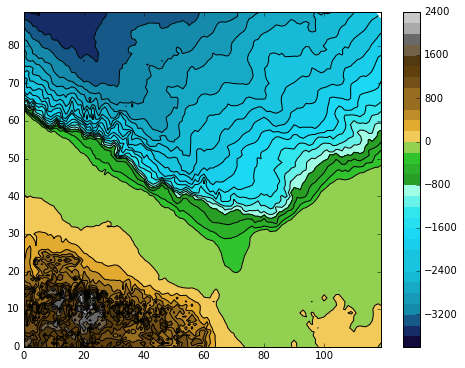

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cs = ax.contourf(z_canyon, 30, cmap=cmap)
ax.contour(z_canyon, 30, linestyles='solid', colors = 'k')
fig.colorbar(cs)
z_canyon.shape

In [25]:
dx = functions_grid.find_dx(lon_g_grid, lat_g_grid)
index = int(extension_m / (dx * 1000))

NameError: name 'lon_g_grid' is not defined

In [16]:
z_cyclic = functions_realistic.cyclic_canyon_truncate(index, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

(90, 120)

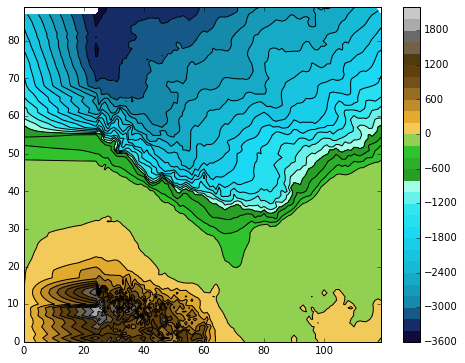

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cs = ax.contourf(z_cyclic, 30, cmap=cmap)
ax.contour(z_cyclic, 30, linestyles='solid', colors = 'k')
fig.colorbar(cs)
z_cyclic.shape

In [23]:
z_model = functions_realistic.canyon_for_model(fluid_depth, index, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

NameError: name 'index' is not defined

NameError: name 'z_model' is not defined

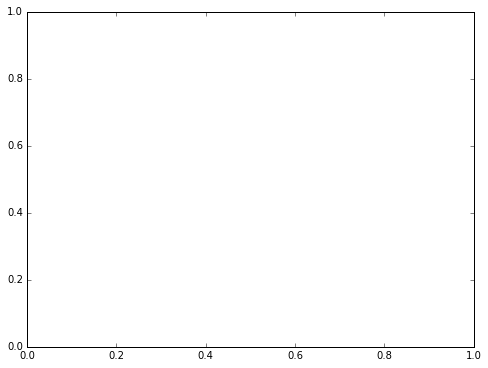

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cs = ax.contourf(z_model, 30, cmap=cmo.cm.matter)
ax.contour(z_model, 50, linestyles='solid', colors = 'k')
fig.colorbar(cs)
z_model.shape

In [23]:
z_original, z_smoothed = functions_realistic.smooth_canyon(max_norm_depth_diff, smooth_factor, fluid_depth, index, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

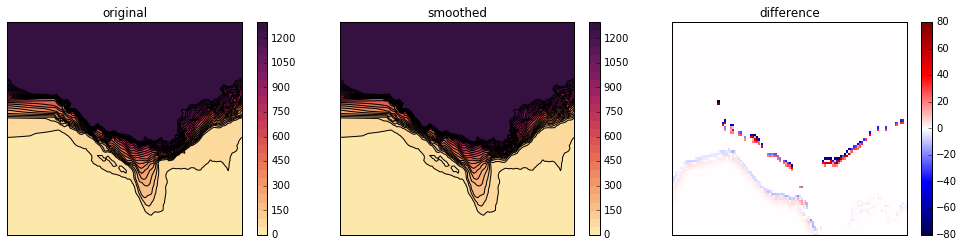

In [24]:
difference = np.subtract(z_smoothed, z_original)
fig, axes = plt.subplots(1,3,figsize=(14,3.5)); plt.tight_layout()
c0 = axes[0].contourf(z_original, 25, cmap = cmo.cm.matter)
c1 = axes[1].contourf(z_smoothed, 25, cmap = cmo.cm.matter)
c2 = axes[2].pcolormesh(difference, cmap = cm.seismic, vmin=-80, vmax=80)
axes[0].contour(z_original, 25, linestyles='solid', colors = 'k')
axes[1].contour(z_smoothed, 25, linestyles='solid', colors = 'k')
for cs, i, ttl in zip([c0, c1, c2], np.arange(3), ['original', 'smoothed', 'difference']):
    fig.colorbar(cs, ax = axes[i]); axes[i].set_title(ttl)
    axes[i].xaxis.set_visible(False); axes[i].yaxis.set_visible(False)

# 7. Idealized Canyon

In [36]:
xsize, ysize = x_final-2, y_final-2

x_wall_ideal = x_wall_ext

p_one = [lon_s_grid[-1,-1], lat_s_grid[-1,-1]]
p_two = [lon_s_grid[-1,0], lat_s_grid[-1,0]]
y_wall_ideal = functions_grid.find_distance(p_one, p_two)

In [43]:
y_diff = y_wall_ideal - y_wall

y_base_ideal = y_base + y_diff
y_break_ideal = y_break + y_diff
y_head_ideal = y_head + y_diff
y_coast_ideal = y_coast + y_diff

In [44]:
x, y, y_edge, X, Y = functions_idealized.set_domain_grid(xsize, ysize, x_wall_ideal, y_wall_ideal)

bathymetry = functions_idealized.make_topo_smooth(y_edge, y_base_ideal, y_break_ideal, y_head_ideal, y_coast_ideal,
                                                  cR, L, x, x_wall, w_break, w_mid, w_head, p,
                                                  fluid_depth, z_bottom, z_break, z_wall)

(87, 117)

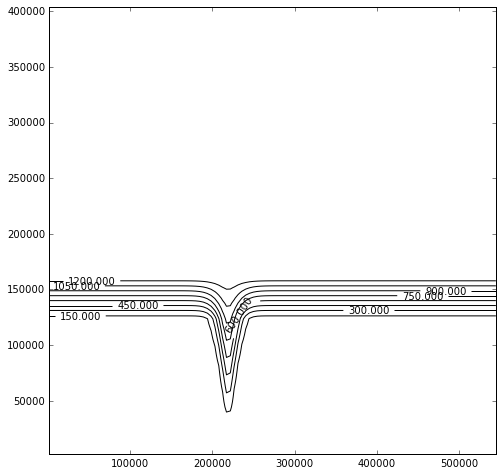

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cs = ax.contour(X, Y, bathymetry, 10, colors='k', linestyles='solid')
CS = ax.contour(X, Y, bathymetry, levels = [-1300, -80, -60, -40.1], colors='k',linestyles='solid')
ax.clabel(cs, inline=1); ax.clabel(CS, inline=1)

bathymetry.shape